<a href="https://colab.research.google.com/github/UofGAnalytics/BOLDscalable/blob/master/coursematerial/week7/simple_rnn_future.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(20)

## Create some random data that is somewhat predictable

In [2]:
# 442 data points with some autocorrelation:
#difference between each value and the next value weighted sum of a previous step 
#and a current random noraml variable

N=442

# weight is how much previous steps affect the current step
weight = 0.60 # original
#weight = 0.99 # highly correlated
#weight = 0 # unpredictable
ts = np.zeros(N)


# first step is a random jump
ts[1] = ts[0]+np.random.normal()

for i in range(2,N):
    rn = np.random.normal()
    prev_step = ts[i-1]-ts[i-2]
    # each step is a combination of the current random jump and the previous step
    ts[i] = ts[i-1]+(weight*prev_step) + (1.0-weight)*rn
    


## Plot the generated data

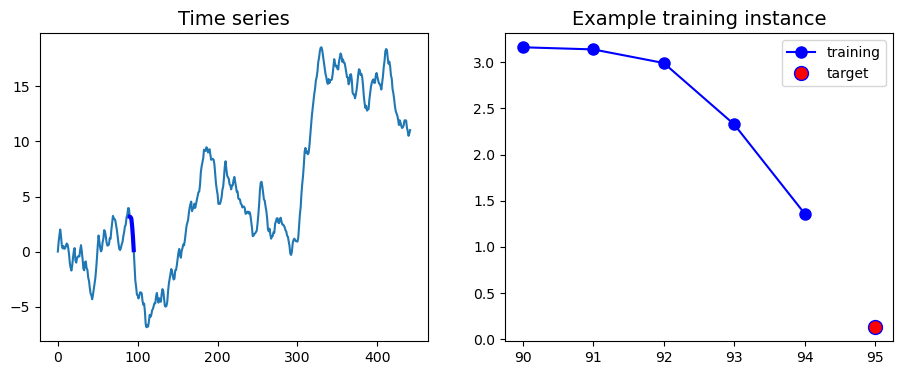

In [3]:

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(ts)
plt.plot(np.arange(90,96),ts[90:96], "b-", linewidth=3, label="A training instance")
plt.title("Time series", fontsize=14)


plt.subplot(122)
plt.title("Example training instance", fontsize=14)
plt.plot(np.arange(90,95),ts[90:95], "bo-", markersize=8, label="training")
plt.plot(np.arange(95,96),ts[95:96], "bo", markersize=10, label="target", markerfacecolor='red')
plt.legend(loc="best")

plt.show()
# we are going to pass 5 of these values in order and going to predict what's going to come next

## Set parameters and process the data

In [4]:

n_window = 5   # size of the sequence to use for prediction
n_input =  1   # dimension of the input data
n_output = 1   # dimension of the prediction
size_train = 401 # how much training data to use, keep one for the final target
n_neurons = 32  # number of neurons in each cell 

#in more complicated tasks both input and output coudl be multi-dimensional

# Split the data into training and test data
train = ts[:size_train]
test = ts[size_train:]

# reshape into batches of length given by window
X_batch = train[:-1].reshape(-1, n_window, n_input)
Y_batch = train[n_window::n_window].reshape(-1, n_input)

X_test = test[:-1].reshape(-1, n_window, n_input)
Y_test = test[n_window::n_window].reshape(-1, n_input)


In [5]:
print(X_batch.shape, Y_batch.shape) #80 sequences, each of 5 values one dimensional - 80 samples corresponding to the target
print(X_test.shape, Y_test.shape) #same bu far fewer points

(80, 5, 1) (80, 1)
(8, 5, 1) (8, 1)


## Plot some example training data

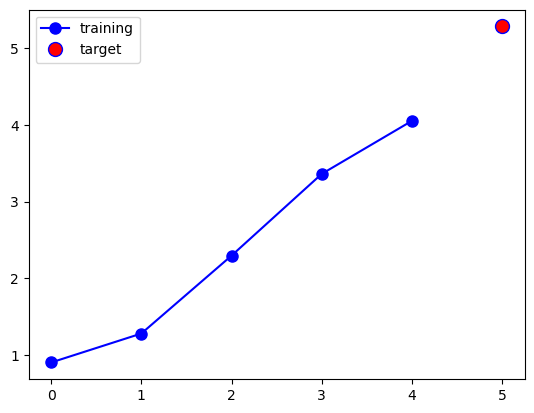

In [6]:
i=60
plt.plot(X_batch[i], "bo-", markersize=8, label="training")
plt.plot([5],Y_batch[i], "bo", markersize=10, label="target", markerfacecolor='red')
plt.legend(loc="best")
plt.show()

## Create the RNN

In [7]:
rnn_cell = tf.keras.layers.SimpleRNNCell(units=n_neurons, activation=tf.nn.relu)   
rnn_layer = tf.keras.layers.RNN(rnn_cell)
prediction_layer = tf.keras.layers.Dense(1)

def predict(x):

    x = rnn_layer(x)
    prediction = prediction_layer(x)

    return prediction

def loss(x,y):
    prediction = predict(x)
    loss = tf.reduce_mean(tf.square(prediction - y))  
    return loss


## Set-up the training

In [8]:

lr = 0.01
train_steps = 2000
# we'll use the Adam optimizer instead of gradient descent.
optimizer = tf.optimizers.Adam(lr)

## Train the model

In [9]:
for i in range(train_steps):
    with tf.GradientTape() as tape:
        current_loss = loss(X_batch,Y_batch)
        gradients = tape.gradient(current_loss, tape.watched_variables())
        optimizer.apply_gradients(zip(gradients, tape.watched_variables()))
        if i%100 == 0:
            print('Training Step:' + str(i) + ' Loss = ' + str(current_loss))
y_pred = predict(X_test)

2023-06-19 15:06:54.216255: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 15:06:54.947327: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7426 MB memory:  -> device: 0, name: Tesla M60, pci bus id: 0001:00:00.0, compute capability: 5.2


Training Step:0 Loss = tf.Tensor(98.52358, shape=(), dtype=float32)
Training Step:100 Loss = tf.Tensor(0.18815562, shape=(), dtype=float32)
Training Step:200 Loss = tf.Tensor(0.163486, shape=(), dtype=float32)
Training Step:300 Loss = tf.Tensor(0.14910457, shape=(), dtype=float32)
Training Step:400 Loss = tf.Tensor(0.12546346, shape=(), dtype=float32)
Training Step:500 Loss = tf.Tensor(0.104938984, shape=(), dtype=float32)
Training Step:600 Loss = tf.Tensor(0.09590857, shape=(), dtype=float32)
Training Step:700 Loss = tf.Tensor(0.09162925, shape=(), dtype=float32)
Training Step:800 Loss = tf.Tensor(0.08648571, shape=(), dtype=float32)
Training Step:900 Loss = tf.Tensor(0.08424479, shape=(), dtype=float32)
Training Step:1000 Loss = tf.Tensor(0.08694964, shape=(), dtype=float32)
Training Step:1100 Loss = tf.Tensor(0.08051442, shape=(), dtype=float32)
Training Step:1200 Loss = tf.Tensor(0.07712711, shape=(), dtype=float32)
Training Step:1300 Loss = tf.Tensor(0.074934594, shape=(), dtype=f

## Plot the predictions

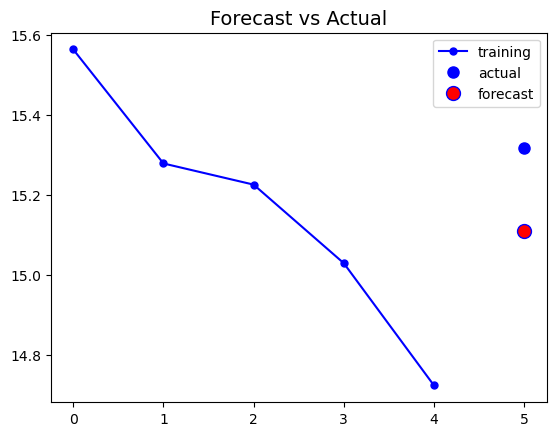

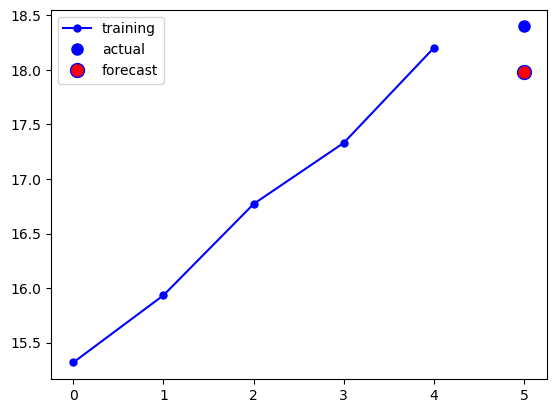

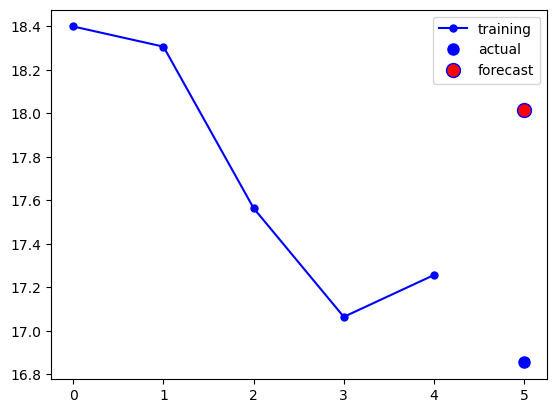

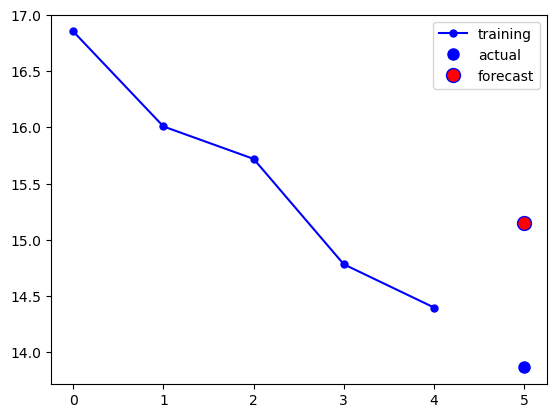

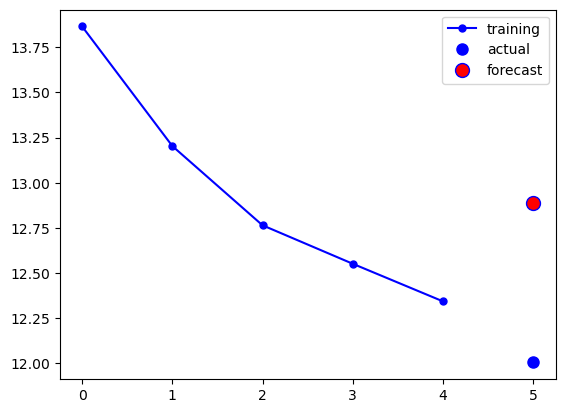

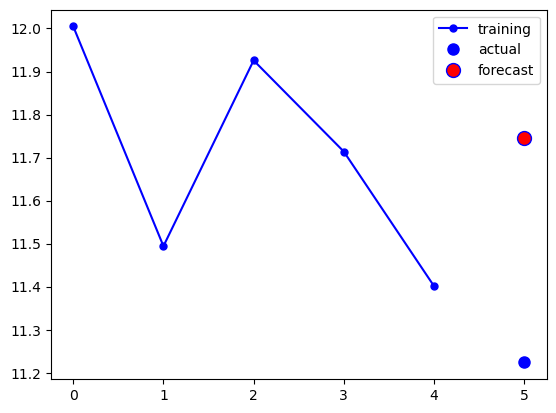

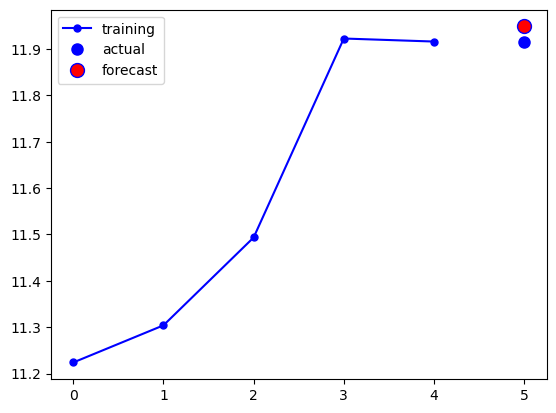

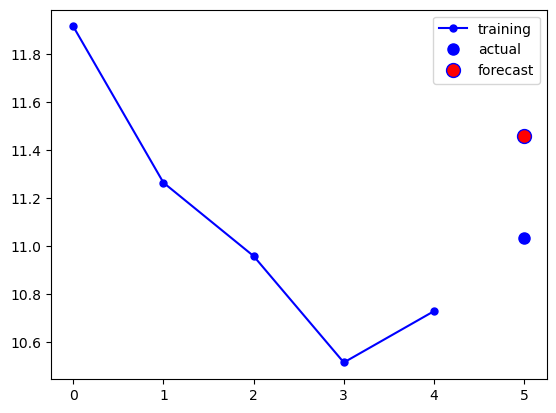

In [10]:
plt.title("Forecast vs Actual", fontsize=14)

for i in range(8):
    #plt.plot(np.append(X_test[i,:,0],Y_test[i]), "bo-", markersize=5, label="training")
    plt.plot(X_test[i,:,0], "bo-", markersize=5, label="training")
    plt.plot([5],Y_test[i], "bo", markersize=8, label="actual")
    plt.plot([5],y_pred[i], "bo", markersize=10, label="forecast", markerfacecolor='red')
    plt.legend(loc="best")

    plt.show()
